Source: https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis/notebook 

In [5]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install matplotlib 
!pip install keras
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.0 MB/s eta 0:00:00


In [6]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import keras
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kellyg/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


In [11]:
# dataset_filename = os.listdir("../input")[0]
# dataset_path = os.path.join("..","input",'/Users/kellyg/chat_from_medium/tweets_2.csv')
print("Open file:", '/Users/kellyg/chat_from_medium/tweets_2.csv')
df = pd.read_csv('/Users/kellyg/chat_from_medium/tweets_2.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /Users/kellyg/chat_from_medium/tweets_2.csv


In [12]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [13]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [14]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [15]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 221 ms, sys: 11.2 ms, total: 232 ms
Wall time: 240 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

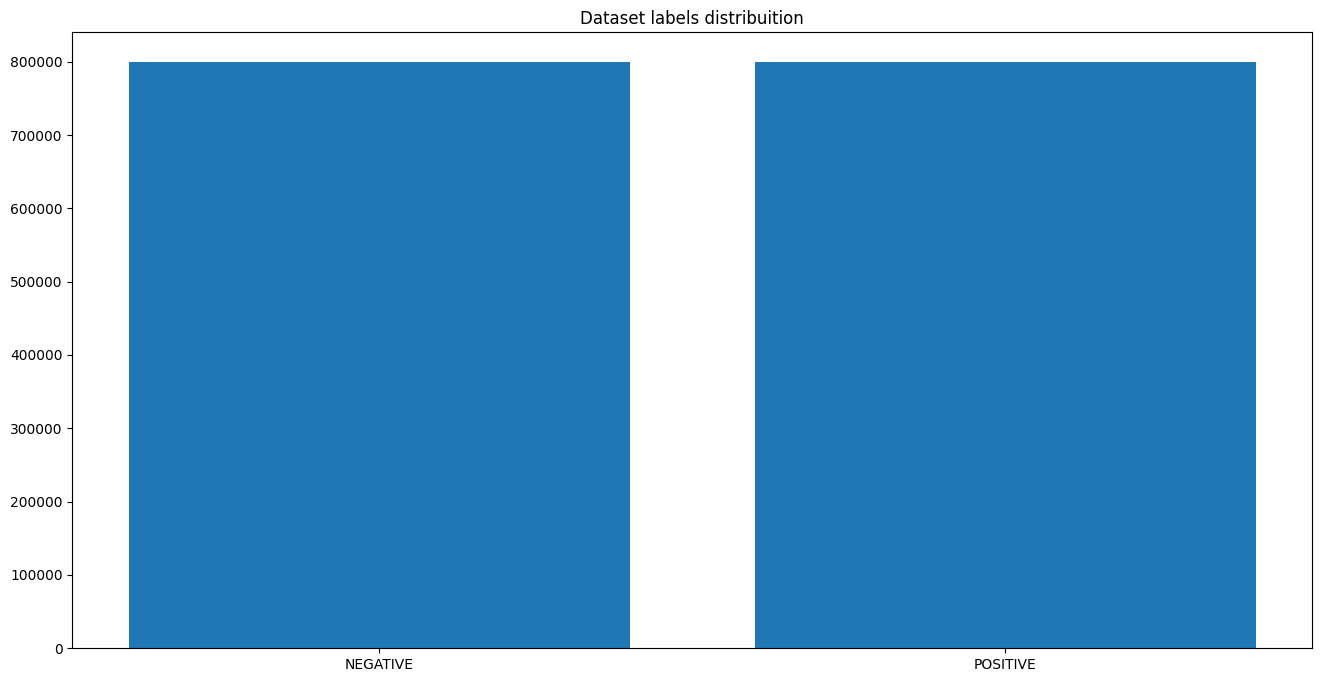

In [16]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [17]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [18]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [19]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 27.5 s, sys: 232 ms, total: 27.8 s
Wall time: 27.8 s


In [20]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [21]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 1.72 s, sys: 201 ms, total: 1.92 s
Wall time: 2.09 s


In [23]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                             window=W2V_WINDOW, 
                                             min_count=W2V_MIN_COUNT, 
                                             workers=8)

2025-03-30 22:14:56,849 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2025-03-30T22:14:56.849576', 'gensim': '4.3.3', 'python': '3.10.16 (main, Mar 24 2025, 02:58:52) [Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5-arm64-arm-64bit', 'event': 'created'}


In [24]:
w2v_model.build_vocab(documents)

2025-03-30 22:15:04,654 : INFO : collecting all words and their counts
2025-03-30 22:15:04,656 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-30 22:15:04,690 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2025-03-30 22:15:04,715 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2025-03-30 22:15:04,755 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2025-03-30 22:15:04,787 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2025-03-30 22:15:04,802 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2025-03-30 22:15:04,812 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2025-03-30 22:15:04,830 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2025-03-30 22:15:04,842 : INFO : PROGRESS: at s

In [26]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [27]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2025-03-30 22:16:01,251 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2025-03-30T22:16:01.251732', 'gensim': '4.3.3', 'python': '3.10.16 (main, Mar 24 2025, 02:58:52) [Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5-arm64-arm-64bit', 'event': 'train'}
2025-03-30 22:16:02,304 : INFO : EPOCH 0 - PROGRESS: at 20.27% examples, 1662558 words/s, in_qsize 15, out_qsize 0
2025-03-30 22:16:03,308 : INFO : EPOCH 0 - PROGRESS: at 40.73% examples, 1669770 words/s, in_qsize 15, out_qsize 0
2025-03-30 22:16:04,324 : INFO : EPOCH 0 - PROGRESS: at 60.52% examples, 1648175 words/s, in_qsize 15, out_qsize 0
2025-03-30 22:16:05,334 : INFO : EPOCH 0 - PROGRESS: at 79.16% examples, 1615248 words/s, in_qsize 15, out_qsize 0
2025-03-30 22:16:06,339 : INFO : EPOCH 0 - PROGRESS: at 99.12% examples, 1618288 words/s, in_qsize 7, out_qsize 3
2025-03-30 

CPU times: user 14min 27s, sys: 9.26 s, total: 14min 36s
Wall time: 2min 45s


(263120991, 295270464)

In [29]:
w2v_model.wv.most_similar("love")

[('luv', 0.5708178877830505),
 ('loved', 0.5618874430656433),
 ('loves', 0.5546414256095886),
 ('adore', 0.5186512470245361),
 ('amazing', 0.5168121457099915),
 ('looove', 0.495199978351593),
 ('awesome', 0.4765596389770508),
 ('loooove', 0.4724890887737274),
 ('loove', 0.446450799703598),
 ('loveee', 0.43648168444633484)]

In [30]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 7.86 s, sys: 130 ms, total: 7.99 s
Wall time: 8.12 s


In [31]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 10.3 s, sys: 1.55 s, total: 11.8 s
Wall time: 12.8 s


In [32]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [33]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [34]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [35]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [36]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [37]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

/Users/kellyg/chat_from_medium/venv_tf/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    87,125,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,125,700 (332.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 87,125,700 (332.36 MB)

In [39]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [40]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')/


In [48]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[early_stopping])


Epoch 1/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3287s 3s/step - accuracy: 0.7707 - loss: 0.4738 - val_accuracy: 0.7856 - val_loss: 0.4537
Epoch 2/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4395s 4s/step - accuracy: 0.7743 - loss: 0.4684 - val_accuracy: 0.7873 - val_loss: 0.4531
Epoch 3/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3196s 3s/step - accuracy: 0.7756 - loss: 0.4658 - val_accuracy: 0.7870 - val_loss: 0.4533
Epoch 4/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3580s 3s/step - accuracy: 0.7758 - loss: 0.4671 - val_accuracy: 0.7893 - val_loss: 0.4494
Epoch 5/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4857s 4s/step - accuracy: 0.7772 - loss: 0.4648 - val_accuracy: 0.7895 - val_loss: 0.4492
Epoch 6/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3937s 4s/step - accuracy: 0.7777 - loss: 0.4622 - val_accuracy: 0.7899 - val_loss: 0.4478
Epoch 7/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3673s 3s/step - accuracy: 0.7781 - loss: 0.4621 - val_accuracy: 0.7909 - val_loss: 0.4463
Epoch 8/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3257s 3s/step - accuracy: 0.7787 - loss: 0

In [49]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])


313/313 ━━━━━━━━━━━━━━━━━━━━ 232s 740ms/step - accuracy: 0.7919 - loss: 0.4450

ACCURACY: 0.7915187478065491
LOSS: 0.44610482454299927
CPU times: user 14min 59s, sys: 3min 39s, total: 18min 38s
Wall time: 3min 52s


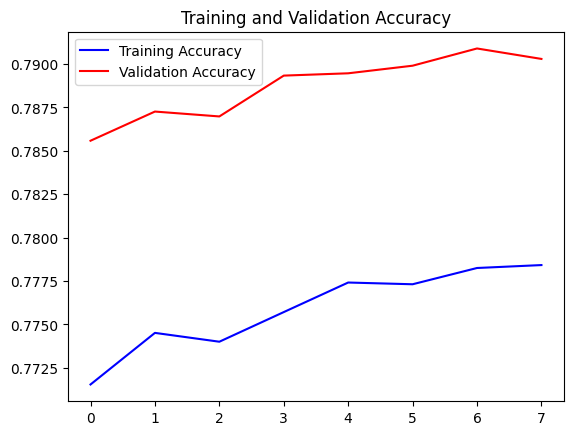

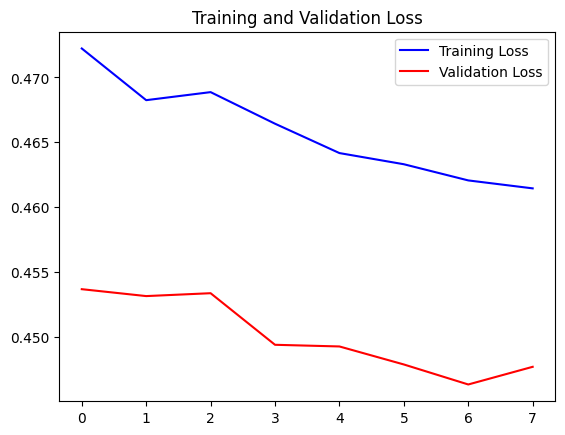

In [52]:
acc = history.history['accuracy']  # Change 'acc' to 'accuracy'
val_acc = history.history['val_accuracy']  # Change 'val_acc' to 'val_accuracy'
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
 
plt.show()


In [53]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE


In [54]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [63]:
predict("Hi! I'm excited to talk to you today. How are you?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_36232/1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'POSITIVE',
 'score': 0.9814221858978271,
 'elapsed_time': 0.14696121215820312}

In [65]:
predict("You're not a real person, this is pointless.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_36232/1332943948.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEGATIVE',
 'score': 0.31623169779777527,
 'elapsed_time': 0.1217501163482666}

In [66]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 ━━━━━━━━━━━━━━━━━━━━ 249s 6s/step
CPU times: user 13min 27s, sys: 4min 6s, total: 17min 33s
Wall time: 4min 9s


In [68]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)


    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)


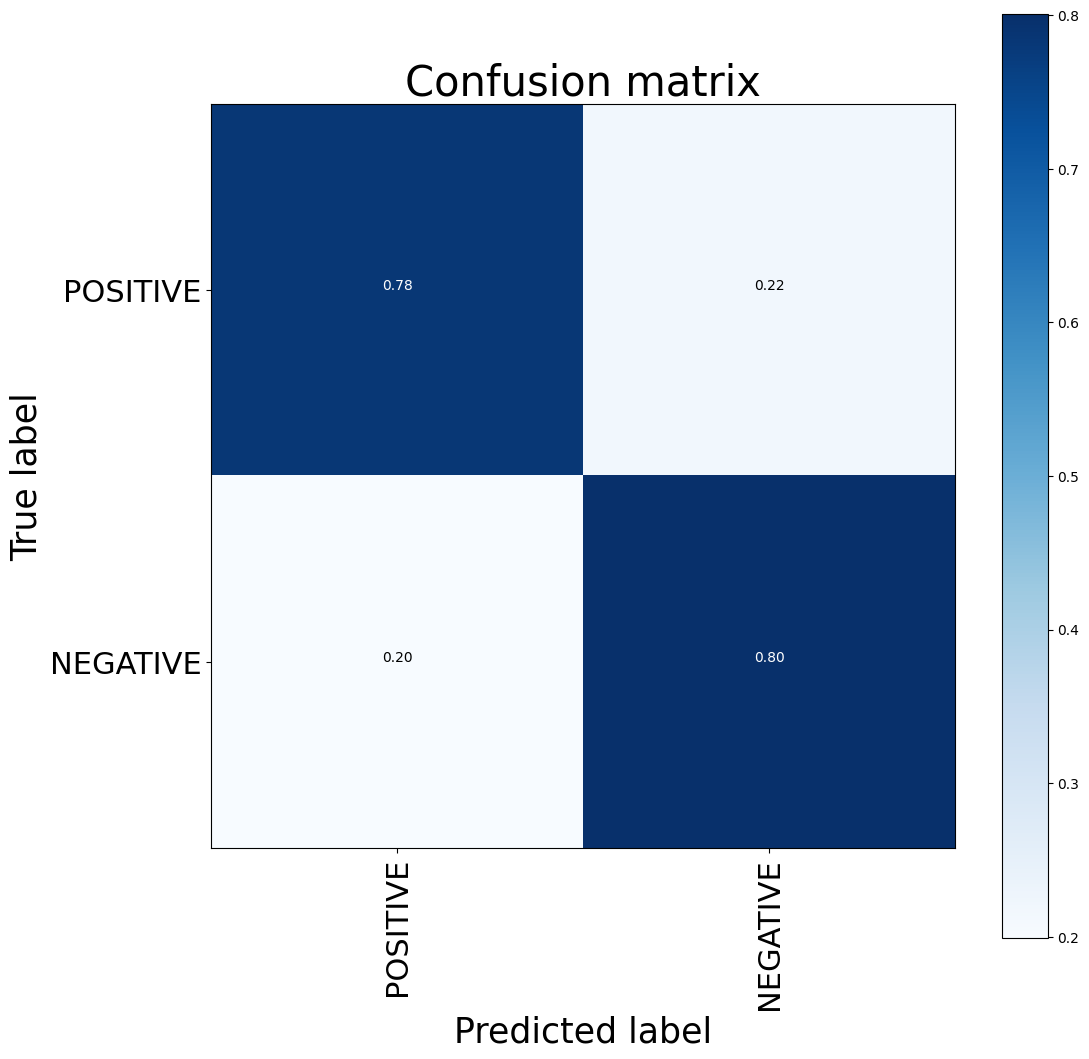

CPU times: user 728 ms, sys: 53.3 ms, total: 782 ms
Wall time: 704 ms


In [69]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [70]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [71]:
accuracy_score(y_test_1d, y_pred_1d)

0.79151875

In [72]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2025-03-31 22:31:08,906 : WARNING : You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-03-31 22:31:09,646 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-31T22:31:09.645823', 'gensim': '4.3.3', 'python': '3.10.16 (main, Mar 24 2025, 02:58:52) [Clang 14.0.0 (clang-1400.0.29.202)]', 'platform': 'macOS-12.5-arm64-arm-64bit', 'event': 'saving'}
2025-03-31 22:31:09,651 : INFO : not storing attribute cum_table
2025-03-31 22:31:10,167 : INFO : saved model.w2v


In [74]:
pip install tensorflowjs

  Using cached ml_dtypes-0.5.1-cp310-cp310-macosx_10_9_universal2.whl.metadata (21 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-2.19.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-5.29.4-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 MB 17.2 MB/s eta 0:00:0000:0100:01
Using cached tensorflow-2.19.0-cp310-cp310-macosx_12_0_arm64.whl (252.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 29.9 MB/s eta 0:00:00 0:00:01
Using cached tf_keras-2.19.0-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.5.1-cp310-cp310-macosx_10_9_universal2.whl (671 

In [77]:
import pickle
import json

# Convert tokenizer
with open("/Users/kellyg/chat_from_medium/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
with open("/Users/kellyg/chat_from_medium/tokenizer.json", "w") as f:
    json.dump(tokenizer, f)

# Convert encoder
with open("/Users/kellyg/chat_from_medium/encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
with open("/Users/kellyg/chat_from_medium/encoder.json", "w") as f:
    json.dump(encoder, f)

print("Conversion completed!")

TypeError: Object of type Tokenizer is not JSON serializable

https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis/notebook